In [1]:
import numpy as np
import matplotlib as plt
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML, display

def play_video(video, figsize=(5, 5), fps=5, vmin=None, vmax=None, save_path=None):
    """
    Displays a stack of images as a video inside jupyter notebooks with consistent intensity scaling.

    Parameters
    ----------
    video : ndarray
        Stack of images.
    figsize : tuple, optional
        Canvas size of the video.
    fps : int, optional
        Video frame rate.
    vmin : float, optional
        Minimum intensity value for all frames. If None, will be automatically determined.
    vmax : float, optional
        Maximum intensity value for all frames. If None, will be automatically determined.

    Returns
    -------
    Video object
        Returns a video player with input stack of images.
    """
    fig = plt.figure(figsize=figsize)
    images = []

    if(len(video.shape) == 3):
        video = np.expand_dims(video,axis=-1)

    plt.axis("off")
    
    # If vmin/vmax not provided, compute global min/max across all frames
    if vmin is None:
        vmin = np.min([frame[:, :, 0].min() for frame in video])
    if vmax is None:
        vmax = np.max([frame[:, :, 0].max() for frame in video])
    mean = np.mean(video)

    print(f"vmin: {vmin} vmax: {vmax} mean: {mean:.2f}")

    for image in video:
        images.append([plt.imshow(image[:, :, 0], cmap="gray", vmin=vmin, vmax=vmax)])

    anim = animation.ArtistAnimation(
        fig, images, interval=1e3 / fps, blit=True, repeat_delay=0
    )

    html = HTML(anim.to_jshtml())
    display(html)

    # Save the animation if a save path is provided
    if save_path:
        if save_path.endswith('.mp4'):
            # Use FFMpegWriter for MP4 files (requires FFmpeg installed)
            writer = animation.FFMpegWriter(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
            anim.save(save_path, writer=writer)
            print(f"Animation saved to {save_path}")
        elif save_path.endswith('.gif'):
            # Use PillowWriter for GIF files
            writer = animation.PillowWriter(fps=fps)
            anim.save(save_path, writer=writer)
            print(f"Animation saved to {save_path}")
        else:
            print("Unsupported file format. Use .mp4 or .gif extension.")
    plt.close()

In [2]:
import torch

# Load a validation set and check video

val_data = np.load('../validation_data_no_noise.npz')
val_videos = torch.Tensor(val_data['vids'])
val_displacements = torch.Tensor(val_data['disp'])
val_labels = torch.Tensor(val_data['labels'])
D_max_normalization = 1
val_labels = val_labels / np.array([D_max_normalization, D_max_normalization, 1])

In [3]:
play_video(val_videos[0])

vmin: -0.23201902210712433 vmax: 0.7157734036445618 mean: -0.13


In [2]:
from simulation import *

# Image parameters
N = 1 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame
# values from Real data
background_mean,background_sigma = 1420, 290
part_mean, part_std = 6000 - background_mean,500

image_props = {
    "n_pos_per_frame": nPosPerFrame,
    "frames": nFrames,
    "particle_intensity": [
        part_mean,
        part_std,
    ],  # Mean and standard deviation of the particle intensity
    "NA": 1.46,  # Numerical aperture
    "wavelength": 500e-9,  # Wavelength
    "psf_division_factor": 1.3,  
    "resolution": 100e-9,  # Camera resolution or effective resolution, aka pixelsize
    "output_size": 9,
    "upsampling_factor": 5,
    "background_intensity": [
        background_mean,
        background_sigma,
    ],  # Standard deviation of background intensity within a video
    "poisson_noise": 100, # -1 for no noise
    "gaussian_noise": True,
    "trajectory_unit" : 1200,
    "D_min": 1, # >= 1
    "D_max": 10,
    "angle_max": np.pi,
    "D_max_norm": 1, # factor to divide by for normalization
}

np.random.seed(143)
videos, _, labels = create_training_set_w_features(N, T, image_props)

In [3]:
image_props = {
    "n_pos_per_frame": nPosPerFrame,
    "frames": nFrames,
    "particle_intensity": [
        part_mean,
        part_std,
    ],  # Mean and standard deviation of the particle intensity
    "NA": 1.46,  # Numerical aperture
    "wavelength": 500e-9,  # Wavelength
    "psf_division_factor": 1.3,  
    "resolution": 100e-9,  # Camera resolution or effective resolution, aka pixelsize
    "output_size": 9,
    "upsampling_factor": 5,
    "background_intensity": [
        background_mean,
        background_sigma,
    ],  # Standard deviation of background intensity within a video
    "poisson_noise": -1,
    "gaussian_noise": False,
    "trajectory_unit" : 1200,
    "D_min": 1, # >= 1
    "D_max": 10,
    "angle_max": np.pi,
    "D_max_norm": 1, # factor to divide by for normalization
}

np.random.seed(143)
videos2, _, labels2 = create_training_set_w_features(N, T, image_props)

In [4]:
print(labels, labels2)

[[10.          4.05959267  1.47054842]] [[10.          4.05959267  1.47054842]]


In [5]:
print(f"First coefficient: {labels[0,0]}\nSecond coefficient: {labels[0,1]}\nAngle: {labels[0,-1]*180/np.pi}")

First coefficient: 10.0
Second coefficient: 4.059592666058103
Angle: 84.25621815720292


In [6]:
play_video(videos[0])#, save_path='./ex_w_noise_143.gif')

vmin: -0.12416314333677292 vmax: 1.1393245458602905 mean: 0.17


In [7]:
play_video(videos2[0])#, save_path='./ex_no_noise_143.gif')

vmin: -0.23201806843280792 vmax: 0.7627213597297668 mean: -0.13


In [8]:
def plot_trajectories_item_color_coded(ax, trajectories, colors, N_PARTICLES_PLOTTED, FOV, prefix=''):
    starts = [] 
    for i in range(min(len(trajectories), N_PARTICLES_PLOTTED)):
        P = np.stack(trajectories[i])
        x, y = P[:,0], P[:,1]
        starts.append(P[0])
        ax.plot(x, y, color=colors[i], label=f"P{i}")
    starts = np.vstack(starts)
    ax.scatter(starts[:,0], starts[:,1], s=6, facecolors='none', edgecolors='blue', linewidths=1.5)
    ax.set_xlim((0,FOV[0]))
    ax.set_ylim((0,FOV[1])) 
    ax.set_title("Subtrajectories for frame generation")
    #ax.set_title(f"{prefix} Motion Trajectories (first {N_PARTICLES_PLOTTED})")

In [9]:
np.random.seed(143)

p1 = np.random.randint(image_props['D_min'], image_props['D_max']+1, size=N)
alpha = np.random.uniform(0.1, 1, size=N)
p2 = alpha*p1
theta = np.random.uniform(0, image_props['angle_max'], size=N)
fov = np.array([200,200])
    
# Create trajectories
pos = create_trajectories(p1, p2, theta, fov, N, T, 1)

In [10]:
def generate_anisotropic_trajectory(N, steps, dt, D1, D2, THETA):
    np.random.seed(13)
    R = np.array([[np.cos(THETA), -np.sin(THETA)],[np.sin(THETA), np.cos(THETA)]])
    sig = np.sqrt(2.0 * dt * np.array([D1, D2]))  # [σ1, σ2] Std devs along principal axes

    trajectories = []
    for i in range(N):
        trajectory = [np.random.uniform(200/4, 3*200/4, size=2)] # Starting position in the center
        for t in range(1, steps):
            # independent normals along principal axes then rotate
            position = trajectory[-1] + R @ (np.random.normal(0.0, 1.0, size=2) * sig)
            if np.all((position < 0) & (position >= 200)): break
            trajectory.append(position)
        trajectories.append(trajectory)

    return trajectories

In [11]:
t2 = generate_anisotropic_trajectory(N, T, 1, p1[0], p2[0], theta[0])

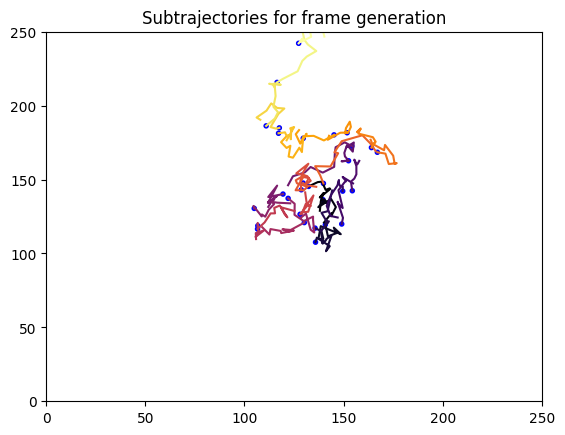

In [12]:
fig, ax = plt.subplots()

# Reshape the trajectories to get sub-segments
frames = pos.reshape(-1, nPosPerFrame, 2)

cmap = plt.colormaps['inferno'].resampled(T//nPosPerFrame)
colors = cmap(np.linspace(0, 1, T//nPosPerFrame)) 

plot_trajectories_item_color_coded(ax, frames, colors, T//nPosPerFrame, fov+50)

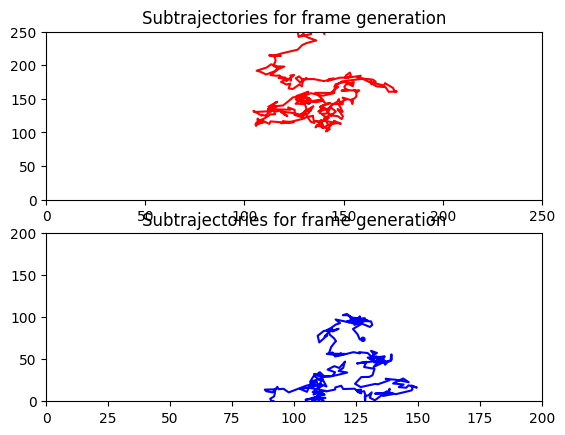

In [13]:
fig, (ax, ax2) = plt.subplots(2,1)

plot_trajectories_item_color_coded(ax, pos, ['r'], N, fov+50)
plot_trajectories_item_color_coded(ax2, t2, ['b'], N, fov)